In [2]:
import os
os.chdir('/lustre/scratch/kiviaho/hillock_club_senescence')

import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from tqdm import tqdm

from scipy.stats import pearsonr


def save_to_pickle(obj,filename):
    import pickle
    with open(filename, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_from_pickle(filename):
    import pickle
    with open(filename, 'rb') as handle:
        obj = pickle.load(handle)
    return obj



In [3]:
## Load the list of markers

# Get the Caronni et al. 2023 PDAC TAM subset gene signature
pdac_tam_markers = pd.read_excel('caronni_et_al_2023_pdac_tam_markers.xlsx')
pdac_tam_markers = pdac_tam_markers[['Gene','Cell_population']].pivot(values='Gene',columns='Cell_population')

for col in pdac_tam_markers:
    pdac_tam_markers[col] = pdac_tam_markers[col].dropna().reset_index(drop=True)

pdac_tam_markers = pdac_tam_markers.dropna(axis=0,how='all')

# Create a dictionary with the lists inside
data_dict = {
    'PDAC Macrophages': ['APOC1','C1QB','APOE','C1QC','C1QA','SPP1','CCL3L1','CCL3','TREM2','MSR1','GPNMB','MS4A7','SLCO2B1','FCGR3A','FCGR2A','MS4A4A','SLC16A10','CD14','CSF1R','RNASE1','CD68','SDS','VSIG4','MRC1','CYBB'],
    'PDAC Neutrophils': ['S100A8','CXCL8','FCGR3B','IL1R2','S100A12','PROK2','NAMPT','CSF3R','CMTM2','S100A9','BCL2A1','AC245128.3','ADGRG3','IFITM2','AL034397.3','SAMSN1','IVNS1ABP','AQP9','PTGS2','GCA','BASP1','G0S2','FPR1','PLEK','PHACTR1','FPR2','LITAF','ANP32A','ACSL1','MNDA','RIPOR2','NCF1','ALOX5AP','CPD','SMIM25','TREM1','IRAK3','SRGN','RNF149','NABP1','LST1','NSMAF','LCP1','MME','SLA','SELL','CXCR2','LCP2','HCAR2','C5AR1'],
    'PDAC Monocytes': ['S100A8','FCN1','S100A9','S100A12','SERPINB2','EREG','CD300E','AC245128.3','APOBEC3A','NLRP3','SLC11A1','AQP9','THBS1','FPR1','MCEMP1','C5AR1','IL1B','SMIM25','ATP2B1-AS1','CSF3R','SLC43A2','CFP','IL1R2','THBD','FPR2'],
    'PDAC Dendritic cells': ['CD1C','CLEC10A','FCER1A','CD1E','HLA-DQB1','HLA-DQA2','HLA-DPB1','HLA-DQA1','HLA-DPA1','S100B','CPVL','HLA-DRB5','HLA-DRA','PKIB','JAML','CSF2RA','HLA-DRB1','CD86','MS4A6A','GPR183','RNASE6','FCGR2B','CD74','IGSF6','HLA-DMB'],
    'PMN-MDSC activity': ['RPL21','XAF1','CLEC5A','CAMP','CD63','LTF','ANXA3','S100A8','OAS2','ALOX5','IFIT1','CD177','S100A9','CEBPE','LCN2','ANXA1','CTSG','MPO','GSTM1','MEGF9','PYGL','PRTN3','YTHDF3','EMILIN1','ELANE','CHI3L1','LTA4H','VILL','HMGN2','C3','MS4A3','ITGAM','CLEC12A','CST7','HSD11B1','C5AR1','F13A1','ADPGK','HP','IDH1','DHRS7','PGLYRP1','MMP9','ALDH3B1','IGSF6','CYBB','AP3S1','NKG7','RAB31','MSRA','OAS3','SLPI','SYNE1','MECR','PRDX5','MCFD2','RAB3D','PILRA','SCP2','ALAS1','CPNE3','NCF1','MAPKAPK3','ACOT7','CD9','IFITM3','MMP8','PLAC8','NAMPT','ZMPSTE24','ARHGDIB','LGALS1','PADI4','ENO1','DSTN','IFI27L1','MYO1F','ETHE1','CEACAM1','SH3BGRL3','GSN'],
    'Hirz MDSCs': ['CEBPB','IL10','NOS2','RORC','S100A8','SOCS1','SOCS3','TGFB1','IL6','CSF2','CSF1','FLT3LG','ARG1','PTGS2','VEGFA','TNF','S100A9','CYBB','NCF1','NCF4','CSF3R','CXCL8','MNDA','LYZ','NCF2','SELL','ICAM1','CD63','CD274','OLR1'],
    'Calcinotto MDSCs': ['CCL15','CCL18','CCL19','CCL20','CCL23','CCL24','CCL27','CCL3','CCL3L3','CCL4','CCL4L2','CXCL10','CXCL12','CXCL13','CXCL16','CXCL6','CXCR1','CXCR2','CXCR3','CXCR4','CXCR5','CXCR6','IFNA1','IFNA10','IFNA13','IFNA14','IFNA16','IFNA17','IFNA2','IFNA21','IFNA4','IFNA5','IFNA6','IFNA7','IFNA8','IFNAR2','IFNB1','IFNG','IL10','IL10RA','IL11RA','IL12A','IL12B','IL12RB1','IL12RB2','IL13','IL17B','IL17F','IL17RA','IL18RAP','IL19','IL1A','IL1B','IL1R2','IL1RAP','IL1RL1','IL1RN','IL21','IL22','IL22RA2','IL23A','IL23R','IL24','IL27','IL2RA','IL2RB','IL2RG','IL4','IL4R','IL5','IL5RA','IL6','IL7','IL7R','IL9','LTA','LTB','LTF','MPO','TGFB2','TNFRSF11B','TNFRSF13C','TNFRSF14','TNFRSF17','TNFRSF18','TNFRSF4','TNFRSF8','TNFSF10','TNFSF11','TNFSF14','TNFSF4','TNFSF8'],
    'Prostate IL1A_B':['IL1A','PTGS2','IL1B','CXCL3','TNFAIP3','IER3','CCL3','NFKBIZ','NFKBIA','CXCL2','SOD2','LUCAT1','PLEK','CCL20','KYNU','G0S2','NAMPT','PNRC1','PPIF','BCL2A1','CD93','EREG','NLRP3','THBS1','AQP9','CD55','ACSL1','FNDC3B','TREM1','C5AR1','ELL2','CD44','DUSP6','AREG','WTAP','TNFAIP6','B4GALT5','GCH1','IL1RN','MXD1','ATP2B1','ATP13A3','EHD1','CXCL1','SLC25A37','SAMSN1','OLR1','ZEB2','EAF1','RNF19B','THBD','OTUD1','CXCL8','ANPEP','SERPINB2','TIMP1','CCL4','CCL3L1','SAV1','BTG1','S100A8','SRGN','ICAM1','GK','FCN1','VCAN','RASGEF1B','MARCKS','S100A9','SLC11A1','NEAT1']
}

# Find the maximum length of the lists
max_length = len(pdac_tam_markers)

# Lengthen each list with np.nan to match the maximum length
for key in data_dict:
    data_dict[key] += [np.nan] * (max_length - len(data_dict[key]))

# Create a DataFrame from the dictionary
new_df = pd.DataFrame(data_dict)

# Assuming pdac_tam_markers is your existing DataFrame
# Concatenate the new DataFrame with pdac_tam_markers
pdac_tam_markers = pd.concat([pdac_tam_markers, new_df], axis=1)

all_genes = [c for c in list(np.array(pdac_tam_markers).ravel()) if not pd.isnull(c)]


##  Lyu et al. 2024 data myeloid cells

### Post scVI integration

In [31]:
adata = sc.read_h5ad('./single-cell/lyu_2024/adata_obj_scvi_myeloid.h5ad')
adata.uns['log1p']["base"] = None

adata.obs['phenotype'] = pd.Categorical(adata.obs['phenotype'],categories=['PCa','mHSPC','mCRPC'])

In [135]:
# Just the myeloid cells
seed = 9642563
sc.pp.neighbors(adata, use_rep='X_scVI', random_state=seed)
sc.tl.umap(adata,random_state=seed)
res_range = [round(x, 2) for x in list(reversed([i/100 for i in range(20,101)]))]
for res in res_range:
    sc.tl.leiden(adata, key_added="leiden_myeloid",resolution=res,random_state=seed)#0.25
    val_counts = adata.obs['leiden_myeloid'].value_counts()
    min_n = val_counts[-1:].iloc[0]
    n_clust = len(val_counts)
    if (min_n >= int(len(adata)*0.05)) & (n_clust < 10): # No cluster should have less than 5% of all cells and there should be no more than 10 clusters
        print(f'{res}: pass, {min_n}, n clusters: {n_clust} !')
    else:
        print(f'{res}: fail, {min_n}, n clusters: {n_clust}')

1.0: fail, 17, n clusters: 17
0.99: fail, 17, n clusters: 18
0.98: fail, 17, n clusters: 17
0.97: fail, 17, n clusters: 17
0.96: fail, 17, n clusters: 17
0.95: fail, 17, n clusters: 17
0.94: fail, 17, n clusters: 16
0.93: fail, 17, n clusters: 17
0.92: fail, 17, n clusters: 15
0.91: fail, 17, n clusters: 16
0.9: fail, 17, n clusters: 15
0.89: fail, 16, n clusters: 15
0.88: fail, 17, n clusters: 15
0.87: fail, 16, n clusters: 15
0.86: fail, 17, n clusters: 13
0.85: fail, 151, n clusters: 13
0.84: fail, 16, n clusters: 14
0.83: fail, 16, n clusters: 14
0.82: fail, 16, n clusters: 15
0.81: fail, 16, n clusters: 14
0.8: fail, 16, n clusters: 14
0.79: fail, 16, n clusters: 14
0.78: fail, 16, n clusters: 14
0.77: fail, 16, n clusters: 14
0.76: fail, 16, n clusters: 14
0.75: fail, 16, n clusters: 14
0.74: fail, 16, n clusters: 13
0.73: fail, 16, n clusters: 13
0.72: fail, 17, n clusters: 12
0.71: fail, 16, n clusters: 13
0.7: fail, 16, n clusters: 13
0.69: fail, 16, n clusters: 13
0.68: fail,

In [32]:
# Just the myeloid cells
res=0.34
seed = 9642563
sc.pp.neighbors(adata, use_rep='X_scVI', random_state=seed)
sc.tl.umap(adata,random_state=seed)
sc.tl.leiden(adata, key_added="leiden_myeloid",resolution=res,random_state=seed)#0.25

adata.obs['leiden_myeloid'].value_counts()

0    2204
1    2129
2    1190
3     843
4     566
5     502
6     487
Name: leiden_myeloid, dtype: int64

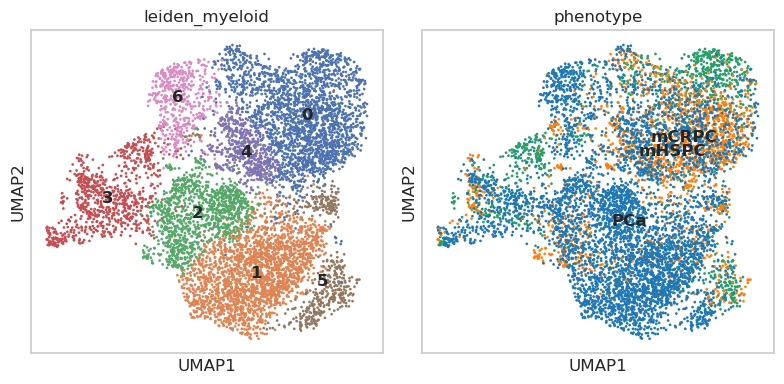

In [34]:
fig,axs = plt.subplots(1,2,figsize=(8,4))
ax = axs[0]
sc.pl.umap(adata, color='leiden_myeloid', ax=ax,show=False,legend_loc="on data")

ax = axs[1]
sc.pl.umap(adata, color='phenotype', ax=ax,show=False,legend_loc="on data")
plt.tight_layout()
plt.show()
#plt.savefig(f'./plots/scs_dataset_umaps/{dataset}_celltype_cluster_umap.png',dpi=120)
#plt.savefig(f'./plots/scs_dataset_umaps/{dataset}_celltype_cluster_umap.pdf')

In [112]:
sc.tl.rank_genes_groups(adata, groupby='leiden_myeloid', groups='all', method='wilcoxon',random_state=3564923058)
deg_df = sc.get.rank_genes_groups_df(adata, group=None, pval_cutoff=0.05, log2fc_min=1)


In [115]:
#deg_df[deg_df['names'].isin(['IL1A','IL1B','PTGS2','TNF','IL23A'])]
deg_df[deg_df['names'].isin(['SPP1','LGALS1','LGALS3','CD9','MARCO'])]
deg_df[deg_df['names'].isin(['FOLR2','SELENOP'])]


,group,names,scores,logfoldchanges,pvals,pvals_adj
5,0,SELENOP,7.323930,1.134905,2.408127e-13,2.357852e-12
2292,5,SELENOP,23.558138,3.603799,1.036037e-122,2.312849e-118
2294,5,FOLR2,20.321218,3.255369,8.347820e-92,6.211891e-88


In [113]:
deg_df[deg_df['group'].isin(['0'])]

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,C1QB,25.315031,1.477564,2.182238e-141,4.163786e-139
1,0,C1QA,24.799290,1.393420,9.124507e-136,1.616631e-133
2,0,C1QC,24.752001,1.446717,2.950291e-135,5.145493e-133
3,0,APOE,12.812212,1.153868,1.400839e-37,4.051678e-36
4,0,APOC1,9.450594,1.067997,3.369145e-21,5.055682e-20
5,0,SELENOP,7.323930,1.134905,2.408127e-13,2.357852e-12
6,0,MTRNR2L12,7.133544,1.176896,9.781658e-13,9.198220e-12
7,0,SLC40A1,7.122010,1.102004,1.063643e-12,9.985179e-12
8,0,RNASE1,6.342861,1.252707,2.255373e-10,1.801394e-09
9,0,AGR2,4.289061,3.027808,1.794305e-05,9.389606e-05


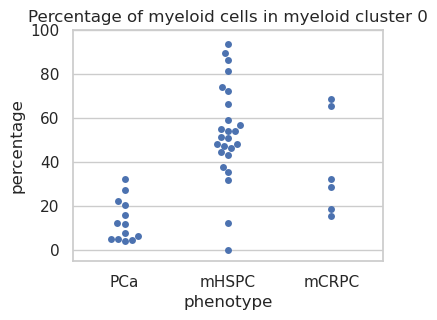

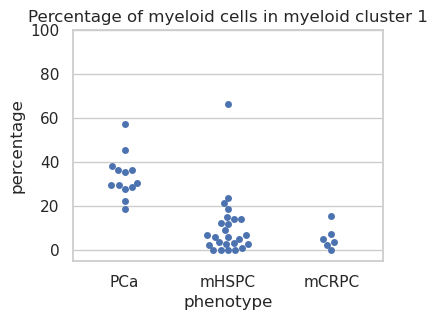

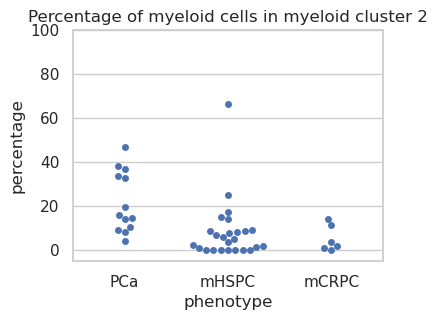

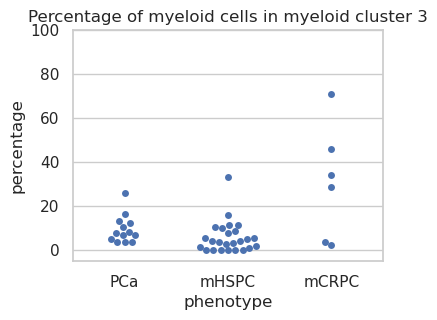

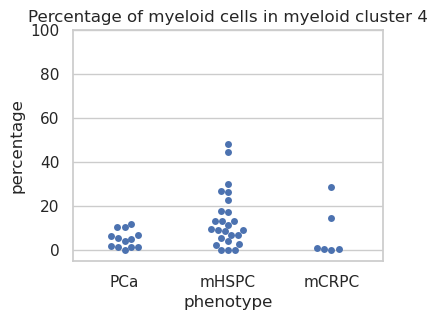

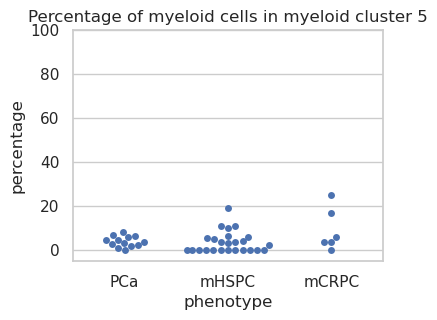

/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 28.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


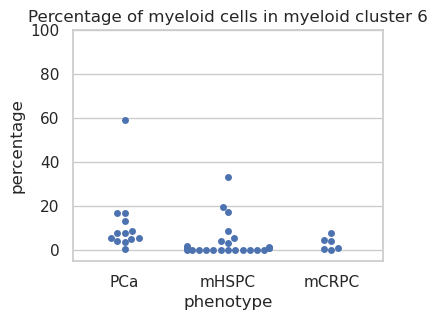

In [40]:
obs_df = adata.obs.copy()
obs_df['count'] = 1 # Add a count term
myeloid_cell_count = obs_df[['sample','count']].groupby('sample').sum()

# Initialize a dataframe for saving the results
myeloid_cluster_pct = pd.DataFrame(index = myeloid_cell_count.index)

for cl in obs_df['leiden_myeloid'].cat.categories:
    obs_subset = obs_df[obs_df['leiden_myeloid'] == cl].copy()
    subset_myeloid_count = obs_df[obs_df['leiden_myeloid'] == cl][['sample','count']].groupby('sample').sum()

    pct_df = subset_myeloid_count / myeloid_cell_count

    pct_df['phenotype'] = pct_df.index.map(obs_df[['sample','phenotype']].groupby('sample').first().to_dict()['phenotype'])
    pct_df['percentage'] = pct_df['count'] * 100

    # Add in the percentage number
    myeloid_cluster_pct[f'myeloid_{cl}'] = pct_df['percentage']

    # Set order
    pct_df['phenotype'] = pd.Categorical(pct_df['phenotype'],categories=['PCa','mHSPC','mCRPC'])

    sns.set_theme(style='whitegrid')
    fig,ax = plt.subplots(figsize=(4,3))
    sns.swarmplot(
        pct_df,
        x = 'phenotype',
        y ='percentage'
        )
    ax.set_ylim(-5,100)
    ax.set_title(f'Percentage of myeloid cells in myeloid cluster {cl}')

    plt.show()

# Save the pct shares of myeloid clusters
myeloid_cluster_pct.to_csv('./lyu_2024_7_myeloid_cluster_pct.csv')

In [147]:
from scipy.stats import ranksums
from itertools import combinations

obs_df = adata.obs.copy()
obs_df['count'] = 1 # Add a count term

myeloid_cell_count = obs_df[['sample','count']].groupby('sample').sum()


for cl in obs_df['leiden_myeloid'].cat.categories:
    
    obs_subset = obs_df[obs_df['leiden_myeloid'] == cl].copy()
    subset_myeloid_count = obs_df[obs_df['leiden_myeloid'] == cl][['sample','count']].groupby('sample').sum()

    pct_df = subset_myeloid_count / myeloid_cell_count

    pct_df['phenotype'] = pct_df.index.map(obs_df[['sample','phenotype']].groupby('sample').first().to_dict()['phenotype'])
    pct_df['percentage'] = pct_df['count'] * 100

    # Set order
    pct_df['phenotype'] = pd.Categorical(pct_df['phenotype'],categories=['PCa','mHSPC','mCRPC'])

    print(cl)
    combs = combinations(pct_df['phenotype'].cat.categories,2)
    for comb in combs:
        grp1 = comb[0]
        grp2 = comb[1]
        stat, pval = ranksums(pct_df[pct_df['phenotype'] == grp1]['percentage'],pct_df[pct_df['phenotype'] == grp2]['percentage'])
        print(f'{grp1} vs {grp2} statistic: {stat:.1f}, p-value: {pval:.2e}')
    print('')

0
PCa vs mHSPC statistic: -4.4, p-value: 1.01e-05
PCa vs mCRPC statistic: -2.5, p-value: 1.10e-02
mHSPC vs mCRPC statistic: 1.4, p-value: 1.47e-01

1
PCa vs mHSPC statistic: 4.5, p-value: 6.55e-06
PCa vs mCRPC statistic: 3.4, p-value: 6.25e-04
mHSPC vs mCRPC statistic: 0.6, p-value: 5.49e-01

2
PCa vs mHSPC statistic: 3.5, p-value: 5.37e-04
PCa vs mCRPC statistic: 2.6, p-value: 8.51e-03
mHSPC vs mCRPC statistic: 0.1, p-value: 8.81e-01

3
PCa vs mHSPC statistic: 2.3, p-value: 2.37e-02
PCa vs mCRPC statistic: -1.2, p-value: 2.19e-01
mHSPC vs mCRPC statistic: -2.2, p-value: 2.44e-02

4
PCa vs mHSPC statistic: -2.3, p-value: 1.94e-02
PCa vs mCRPC statistic: 0.8, p-value: 4.05e-01
mHSPC vs mCRPC statistic: 1.3, p-value: 2.02e-01

5
PCa vs mHSPC statistic: 1.1, p-value: 2.61e-01
PCa vs mCRPC statistic: -0.9, p-value: 3.57e-01
mHSPC vs mCRPC statistic: -1.6, p-value: 1.21e-01

6
PCa vs mHSPC statistic: 3.2, p-value: 1.45e-03
PCa vs mCRPC statistic: 2.3, p-value: 2.26e-02
mHSPC vs mCRPC statis

categories: 0, 1, 2, etc.
var_group_labels: Macrophage, IL1AB immunosuppression, SPP1hi TAMs, etc.


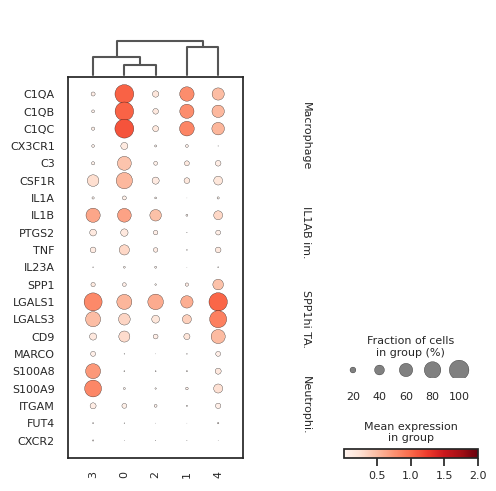

In [106]:
myeloid_subset_markers= {
    'Macrophage':['C1QA','C1QB','C1QC','CX3CR1','C3','CSF1R'],
    'IL1AB immunosuppression':['IL1A','IL1B','PTGS2','TNF','IL23A'],
    'SPP1hi TAMs':['SPP1','LGALS1','LGALS3','CD9','MARCO'],
    'Neutrophil':['S100A8','S100A9','ITGAM','FUT4','CXCR2',],
}

sns.set_theme(style='white', font_scale=0.8)
sc.tl.dendrogram(adata, groupby='leiden_myeloid', use_rep='X_pca')
fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.dotplot(adata, 
    myeloid_subset_markers, 
    groupby='leiden_myeloid', 
    dendrogram=True, 
    log=True, 
    swap_axes=True, 
    ax=ax, 
    vmax=2, 
    show=False)
plt.tight_layout()

## Lyu et al. 2024 Epithelial cells

### Post scVI integration

In [4]:
adata_epi = sc.read_h5ad('./single-cell/lyu_2024/adata_obj_scvi_epithelial.h5ad')
adata_epi.uns['log1p']["base"] = None

adata_epi.obs['phenotype'] = pd.Categorical(adata_epi.obs['phenotype'],categories=['PCa','mHSPC','mCRPC'])

In [5]:
gene_modules = pd.read_excel('./gene_modules.xlsx')
gene_modules_dict = gene_modules.drop(columns=['RANK']).to_dict('list')
for k in gene_modules_dict:
    gene_modules_dict[k] = [g for g in gene_modules_dict[k] if str(g) != 'nan']
print(gene_modules_dict.keys())

for mod in gene_modules_dict:
    lst = gene_modules[mod]
    sc.tl.score_genes(adata_epi, gene_list=lst, use_raw=True, score_name=mod, ctrl_size=len(lst), random_state=23527324)

dict_keys(['PDAC T1RS', 'PDAC IL1B+ Macrophages', 'PDAC scRNAseq Neutrophils', 'Prostate IL1A_B+ MDSCs', 'Prostate IL1A_B+ MDSCs (aggr.)', 'JAK_STAT_FGFR', 'scNMF senescent epithelium', 'scNMF Club interferon', 'Club Henry et al. 2018', 'Hillock Henry et al. 2018', 'Mouse Hillock Montoro et al. 2018', 'Mouse Hillock Luminal Lin et al. 2023'])


In [189]:
# Just the myeloid cells
seed = 350643523
sc.pp.neighbors(adata_epi, use_rep='X_scVI', random_state=seed)
sc.tl.umap(adata_epi,random_state=seed)
res_range = [round(x, 2) for x in list(reversed([i/100 for i in range(20,101)]))]
for res in res_range:
    sc.tl.leiden(adata_epi, key_added="leiden_epithelial",resolution=res,random_state=seed)#0.25
    val_counts = adata_epi.obs['leiden_epithelial'].value_counts()
    min_n = val_counts[-1:].iloc[0]
    n_clust = len(val_counts)
    if (n_clust =< 10): # No cluster should have less than 5% of all cells and there should be no more than 10 clusters
        print(f'{res}: pass, {min_n}, n clusters: {n_clust} !')
        break
    else:
        print(f'{res}: fail, {min_n}, n clusters: {n_clust}')

1.0: fail, 14, n clusters: 21
0.99: fail, 8, n clusters: 23
0.98: fail, 14, n clusters: 19
0.97: fail, 14, n clusters: 21
0.96: fail, 14, n clusters: 20
0.95: fail, 14, n clusters: 19
0.94: fail, 14, n clusters: 20
0.93: fail, 14, n clusters: 20
0.92: fail, 14, n clusters: 20
0.91: fail, 14, n clusters: 19
0.9: fail, 14, n clusters: 20
0.89: fail, 14, n clusters: 20
0.88: fail, 14, n clusters: 19
0.87: fail, 14, n clusters: 19
0.86: fail, 14, n clusters: 21
0.85: fail, 14, n clusters: 19
0.84: fail, 14, n clusters: 20
0.83: fail, 14, n clusters: 19
0.82: fail, 14, n clusters: 19
0.81: fail, 14, n clusters: 17
0.8: fail, 14, n clusters: 16
0.79: fail, 14, n clusters: 18
0.78: fail, 14, n clusters: 17
0.77: fail, 14, n clusters: 17
0.76: fail, 14, n clusters: 17
0.75: fail, 14, n clusters: 17
0.74: fail, 14, n clusters: 17
0.73: fail, 14, n clusters: 15
0.72: fail, 14, n clusters: 15
0.71: fail, 14, n clusters: 14
0.7: fail, 14, n clusters: 15
0.69: fail, 14, n clusters: 15
0.68: fail, 1

In [12]:

# Just the epithelial cells
res=0.73
seed = 350643523
sc.pp.neighbors(adata_epi, use_rep='X_scVI', random_state=seed)
sc.tl.umap(adata_epi,random_state=seed)
sc.tl.leiden(adata_epi, key_added='leiden_epithelial',resolution=res,random_state=seed)#0.25

adata_epi.obs['leiden_epithelial'].value_counts()

# Drop clusters with less than 100 members:
val_counts = adata_epi.obs['leiden_epithelial'].value_counts()
cluster_to_drop = val_counts[val_counts<100].index.tolist()
adata_epi = adata_epi[~(adata_epi.obs['leiden_epithelial'].isin(cluster_to_drop))]

adata_epi.obs['leiden_epithelial'].value_counts()

0     6515
1     4422
2     3198
3     2739
4     2698
5     1524
6     1098
7      671
8      663
9      480
10     422
11     226
12     110
Name: leiden_epithelial, dtype: int64

/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/contextlib.py:119: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


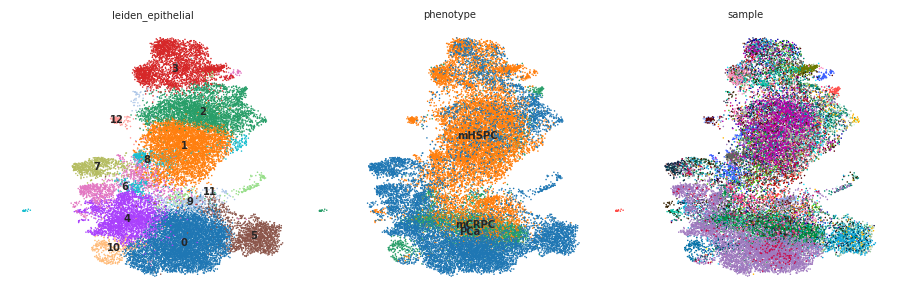

In [13]:
sns.set_theme(style='white',font_scale=0.6)

var_to_plot = ['leiden_epithelial','phenotype','sample']
fig,axs = plt.subplots(1,3,figsize=(9,3))

for i,var in enumerate(var_to_plot):
    
    ax = axs[i]
    if var =='sample':
        sc.pl.umap(adata_epi, color=var, ax=ax,show=False,legend_loc=None)
    else:
        sc.pl.umap(adata_epi, color=var, ax=ax,show=False,legend_loc="on data")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')


plt.tight_layout()

plt.savefig('./plots/scs_dataset_umaps/lyu_2024_epithelial_umap_annotation_umaps.png', dpi=120)
plt.savefig('./plots/scs_dataset_umaps/lyu_2024_epithelial_umap_annotation_umaps.pdf')

plt.show()


In [176]:
#sc.tl.rank_genes_groups(adata_epi, groupby='leiden_epithelial', groups='all', method='wilcoxon',random_state=235247345)
deg_df = sc.get.rank_genes_groups_df(adata_epi, group=None, pval_cutoff=0.05, log2fc_min=1)


In [183]:
deg_df[deg_df['names'].isin(['KRT13','KRT7','KRT4','LGALS3','CRABP2','ELF3','KLF5'])]
#deg_df[deg_df['names'].isin(['LTF','PIGR','CP','MMP7'])]
#deg_df[deg_df['names'].isin(gene_modules_dict['scNMF senescent epithelium'][:10])]
#deg_df[deg_df['group'].isin(['2'])][:30]

,group,names,scores,logfoldchanges,pvals,pvals_adj
354,1,LGALS3,50.074131,1.655855,0.000000e+00,0.000000e+00
391,1,ELF3,39.281075,1.373790,0.000000e+00,0.000000e+00
461,1,KRT7,28.427366,1.148019,9.283270e-178,1.490933e-175
462,1,KLF5,28.427059,1.248943,9.364765e-178,1.493279e-175
517,1,CRABP2,23.793770,1.105106,3.874513e-125,3.760636e-123
1358,2,KRT7,59.496532,3.390773,0.000000e+00,0.000000e+00
1365,2,LGALS3,49.840130,1.906650,0.000000e+00,0.000000e+00
1367,2,ELF3,46.649666,2.235834,0.000000e+00,0.000000e+00
1371,2,CRABP2,43.469509,2.823435,0.000000e+00,0.000000e+00
1434,2,KLF5,23.843113,1.431748,1.193745e-125,2.444877e-123


In [75]:
gene_modules_dict.keys()

dict_keys(['PDAC T1RS', 'PDAC IL1B+ Macrophages', 'PDAC scRNAseq Neutrophils', 'Prostate IL1A_B+ MDSCs', 'Prostate IL1A_B+ MDSCs (aggr.)', 'JAK_STAT_FGFR', 'scNMF senescent epithelium', 'scNMF Club interferon', 'Club Henry et al. 2018', 'Hillock Henry et al. 2018', 'Mouse Hillock Montoro et al. 2018', 'Mouse Hillock Luminal Lin et al. 2023'])

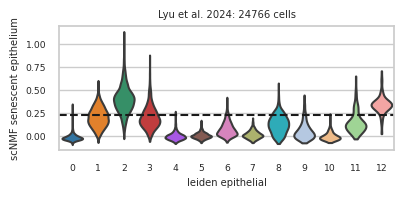

In [28]:
# Visualize the expression of a gene module
sns.set_theme(style='whitegrid',font_scale=0.6)

gset = 'scNMF senescent epithelium'
#gset = 'JAK_STAT_FGFR'
thr_line = adata_epi.obs[gset].quantile(0.75)

fig, ax = plt.subplots(figsize=(4,2))

sc.pl.violin(
    adata_epi,
    groupby='leiden_epithelial',
    use_raw=False,
    keys=gset,
    stripplot=False,
    ax=ax,
    show=False,
)
ax.set_title(f'Lyu et al. 2024: {len(adata_epi)} cells')
#ax.axhline(y=thr_line, linestyle='--',color='k')


plt.savefig('./plots/scs_dataset_umaps/lyu_2024_epithelial_hillock_senescence_score_violin_scvi.png', dpi=120)
plt.savefig('./plots/scs_dataset_umaps/lyu_2024_epithelial_hillock_senescence_score_violin_scvi.pdf')

plt.tight_layout()
plt.show()


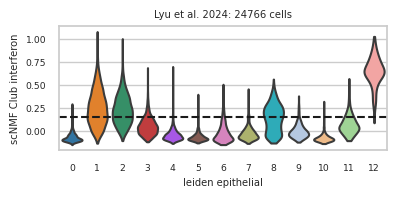

In [29]:
# Visualize the expression of a gene module
sns.set_theme(style='whitegrid',font_scale=0.6)

gset = 'scNMF Club interferon'
fig, ax = plt.subplots(figsize=(4,2))

thr_line = adata_epi.obs[gset].quantile(0.75)

sc.pl.violin(
    adata_epi,
    groupby='leiden_epithelial',
    use_raw=False,
    keys=gset,
    stripplot=False,
    ax=ax,
    show=False,
)
ax.set_title(f'Lyu et al. 2024: {len(adata_epi)} cells')
#ax.axhline(y=thr_line, linestyle='--',color='k')

plt.savefig('./plots/scs_dataset_umaps/lyu_2024_epithelial_club_interferon_score_violin_scvi.png', dpi=120)
plt.savefig('./plots/scs_dataset_umaps/lyu_2024_epithelial_club_interferon_score_violin_scvi.pdf')

plt.tight_layout()
plt.show()


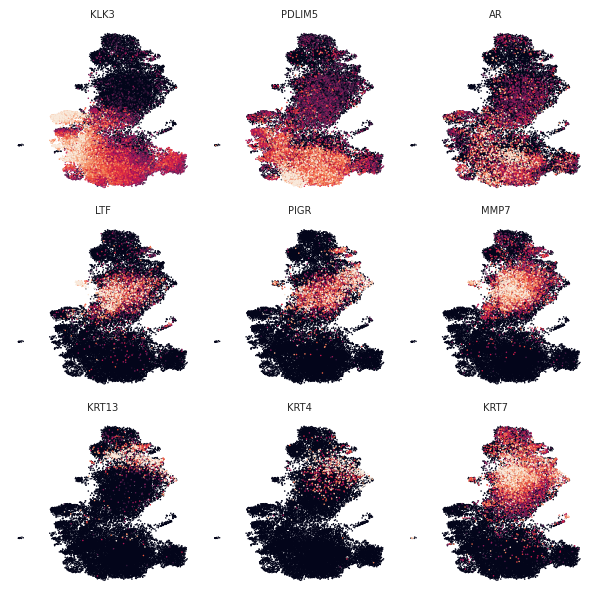

In [14]:
# Visualize gene expression on umap
sns.set_theme(style='white',font_scale=0.6)
genes = ['KLK3','PDLIM5','AR','LTF','PIGR','MMP7','KRT13','KRT4','KRT7']

fig, axs = plt.subplots(3,3,figsize=(6,6))
axs = axs.flatten()
for i, gene in enumerate(genes):
    ax = axs[i]
    sc.pl.umap(
        adata_epi,
        color=gene,
        vmax='p99',
        ax=ax,
        show=False,
        colorbar_loc=None
    )
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

plt.tight_layout()

plt.savefig('./plots/scs_dataset_umaps/lyu_2024_epithelial_gene_markers_umap_grid_scvi.png', dpi=120)
plt.savefig('./plots/scs_dataset_umaps/lyu_2024_epithelial_gene_markers_umap_grid_scvi.pdf')

plt.show()


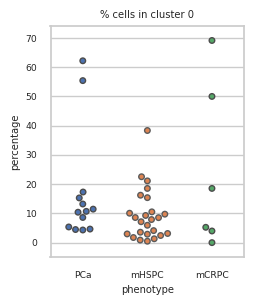

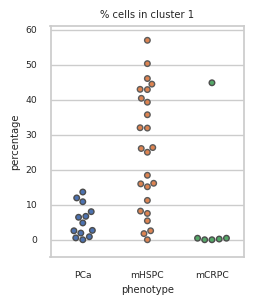

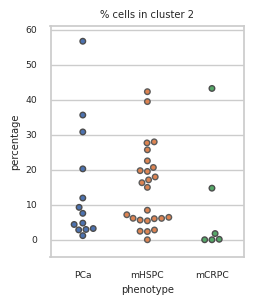

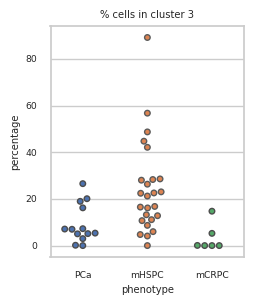

/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


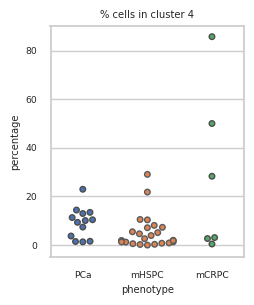

/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 28.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 36.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 36.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


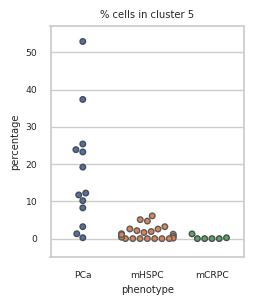

/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 32.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 32.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


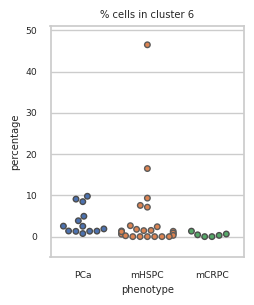

/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 64.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 72.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 72.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


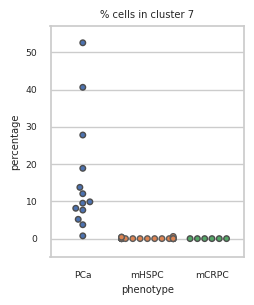

/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 23.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 38.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 36.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.war

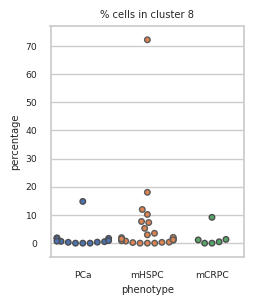

/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 15.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 36.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 30.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 44.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.war

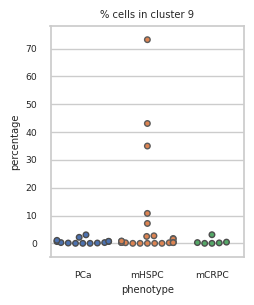

/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 52.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 15.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 60.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 15.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.war

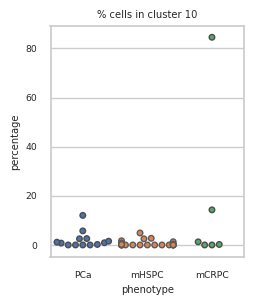

/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 56.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 15.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 64.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 15.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.war

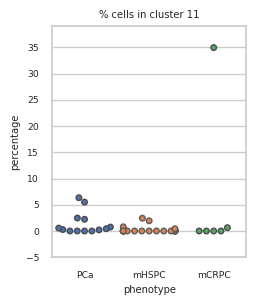

/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 48.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 15.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 56.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 15.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.war

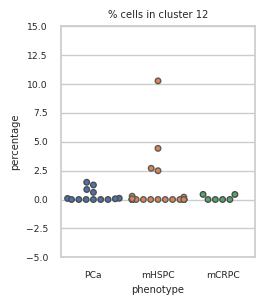

In [46]:
sns.set_theme(style='whitegrid',font_scale=0.6)

obs_df = adata_epi.obs.copy()
obs_df['count'] = 1 # Add a count term

epithelial_cell_count = obs_df[['sample','count']].groupby('sample').sum()
epithelial_cluster_pct = pd.DataFrame(index = epithelial_cell_count.index)

for cl in obs_df['leiden_epithelial'].cat.categories:
    obs_subset = obs_df[obs_df['leiden_epithelial'] == cl].copy()
    subset_myeloid_count = obs_df[obs_df['leiden_epithelial'] == cl][['sample','count']].groupby('sample').sum()

    pct_df = subset_myeloid_count / epithelial_cell_count

    pct_df['phenotype'] = pct_df.index.map(obs_df[['sample','phenotype']].groupby('sample').first().to_dict()['phenotype'])
    pct_df['percentage'] = pct_df['count'] * 100

    # Set order
    pct_df['phenotype'] = pd.Categorical(pct_df['phenotype'],categories=['PCa','mHSPC','mCRPC'])

    epithelial_cluster_pct[f'epithelial_{cl}'] = pct_df['percentage']

    fig,ax = plt.subplots(figsize=(2.5,3))
    sns.swarmplot(
        pct_df,
        x = 'phenotype',
        y ='percentage',
        hue='phenotype',
        legend=False,
        size=4,
        linewidth=1
        )
    ax.set_ylim(-5,int(max(pct_df['percentage'])+5))
    ax.set_title(f'% cells in cluster {cl}')

    plt.savefig(f'./plots/scs_cluster_pct_swarmplots/lyu_2024_epithelial_pct_swarmplot_cluster_{cl}.pdf')

    plt.show()

# Save the pct shares of epithelial clusters
#epithelial_cluster_pct.to_csv('./lyu_2024_15_epithelial_cluster_pct.csv')

In [24]:
from scipy.stats import ranksums
from itertools import combinations

obs_df = adata_epi.obs.copy()
obs_df['count'] = 1 # Add a count term

myeloid_cell_count = obs_df[['sample','count']].groupby('sample').sum()


for cl in obs_df['leiden_epithelial'].cat.categories:
    
    obs_subset = obs_df[obs_df['leiden_epithelial'] == cl].copy()
    subset_myeloid_count = obs_df[obs_df['leiden_epithelial'] == cl][['sample','count']].groupby('sample').sum()

    pct_df = subset_myeloid_count / myeloid_cell_count

    pct_df['phenotype'] = pct_df.index.map(obs_df[['sample','phenotype']].groupby('sample').first().to_dict()['phenotype'])
    pct_df['percentage'] = pct_df['count'] * 100

    # Set order
    pct_df['phenotype'] = pd.Categorical(pct_df['phenotype'],categories=['PCa','mHSPC','mCRPC'])

    print(cl)
    combs = combinations(pct_df['phenotype'].cat.categories,2)
    for comb in combs:
        grp1 = comb[0]
        grp2 = comb[1]
        stat, pval = ranksums(pct_df[pct_df['phenotype'] == grp1]['percentage'],pct_df[pct_df['phenotype'] == grp2]['percentage'])
        print(f'{grp1} vs {grp2} statistic: {stat:.1f}, p-value: {pval:.2e}')
    print('')

0
PCa vs mHSPC statistic: 1.8, p-value: 7.69e-02
PCa vs mCRPC statistic: 0.1, p-value: 9.30e-01
mHSPC vs mCRPC statistic: -0.8, p-value: 4.24e-01

1
PCa vs mHSPC statistic: -3.6, p-value: 3.38e-04
PCa vs mCRPC statistic: 1.9, p-value: 5.37e-02
mHSPC vs mCRPC statistic: 2.5, p-value: 1.43e-02

2
PCa vs mHSPC statistic: -0.5, p-value: 5.90e-01
PCa vs mCRPC statistic: 1.5, p-value: 1.36e-01
mHSPC vs mCRPC statistic: 1.8, p-value: 8.01e-02

3
PCa vs mHSPC statistic: -2.7, p-value: 6.78e-03
PCa vs mCRPC statistic: 2.0, p-value: 4.85e-02
mHSPC vs mCRPC statistic: 3.0, p-value: 2.49e-03

4
PCa vs mHSPC statistic: 2.4, p-value: 1.57e-02
PCa vs mCRPC statistic: -0.5, p-value: 5.99e-01
mHSPC vs mCRPC statistic: -1.5, p-value: 1.34e-01

5
PCa vs mHSPC statistic: 4.1, p-value: 4.56e-05
PCa vs mCRPC statistic: 3.3, p-value: 8.60e-04
mHSPC vs mCRPC statistic: 1.9, p-value: 5.74e-02

6
PCa vs mHSPC statistic: 2.0, p-value: 4.39e-02
PCa vs mCRPC statistic: 3.2, p-value: 1.59e-03
mHSPC vs mCRPC statist

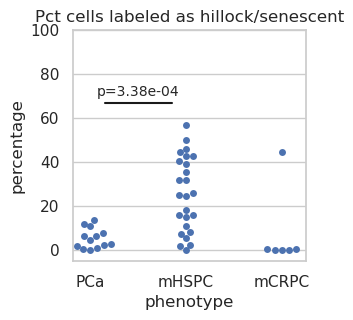

In [153]:

obs_df = adata_epi.obs.copy()
obs_df['count'] = 1 # Add a count term

epithelial_cell_count = obs_df[['sample','count']].groupby('sample').sum()

cl = '1'
obs_subset = obs_df[obs_df['leiden_epithelial'] == cl].copy()
subset_myeloid_count = obs_df[obs_df['leiden_epithelial'] == cl][['sample','count']].groupby('sample').sum()

pct_df = subset_myeloid_count / epithelial_cell_count

pct_df['phenotype'] = pct_df.index.map(obs_df[['sample','phenotype']].groupby('sample').first().to_dict()['phenotype'])
pct_df['percentage'] = pct_df['count'] * 100

# Set order
pct_df['phenotype'] = pd.Categorical(pct_df['phenotype'],categories=['PCa','mHSPC','mCRPC'])

sns.set_theme(style='whitegrid')
fig,ax = plt.subplots(figsize=(3,3))
sns.swarmplot(
    pct_df,
    x = 'phenotype',
    y ='percentage'
    )
ax.set_ylim(-5,100)
ax.set_title(f'Pct cells labeled as hillock/senescent')

ax.text(x = 0.5, y = 70,s='p=3.38e-04',size=10,ha='center')
plt.plot([0.15, 0.85], [67,67],color='k')

plt.show()


In [ ]:
### Compare the shares of myeloid and epithelial cells
epithelial_cluster_pct =  pd.read_csv('./lyu_2024_15_epithelial_cluster_pct.csv',index_col=0)
pct_df =  pd.concat([epithelial_cluster_pct,myeloid_cluster_pct],axis=1)
pct_df

,epithelial_0,epithelial_1,epithelial_2,epithelial_3,epithelial_4,epithelial_5,epithelial_6,epithelial_7,epithelial_8,epithelial_9,...,epithelial_12,epithelial_13,epithelial_14,myeloid_0,myeloid_1,myeloid_2,myeloid_3,myeloid_4,myeloid_5,myeloid_6
sample,,,,,,,,,,,,,,,,,,,,,
sample_1,0.000000,0.000000,0.000000,0.000000,85.714286,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,18.800000,3.600000,2.000000,70.800000,0.400000,3.600000,0.800000
sample_2,18.541997,44.849445,14.738510,14.738510,2.694136,1.267829,0.633914,0.000000,0.475436,0.158479,...,0.000000,0.000000,0.000000,65.662651,7.228916,3.614458,2.409639,14.457831,6.024096,0.602410
sample_3,50.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,28.571429,0.000000,14.285714,28.571429,28.571429,0.000000,0.000000
sample_4,5.240175,0.436681,43.231441,5.240175,0.436681,0.000000,0.436681,0.000000,9.170306,0.436681,...,0.436681,0.000000,0.000000,15.384615,15.384615,11.538462,46.153846,0.000000,3.846154,7.692308
sample_5,69.134971,0.201952,0.134635,0.067317,28.306967,0.235611,0.302928,0.000000,1.144396,0.269270,...,0.000000,0.000000,0.000000,68.973214,5.133929,0.000000,3.794643,0.892857,16.964286,4.241071
sample_6,3.982301,0.442478,1.769912,0.000000,3.097345,0.000000,1.327434,0.000000,1.327434,3.097345,...,0.442478,0.000000,0.000000,32.244898,2.448980,0.816327,34.285714,0.408163,25.306122,4.489796
sample_7,1.315789,25.000000,39.473684,26.315789,1.315789,0.000000,0.000000,0.000000,5.263158,0.000000,...,0.000000,0.000000,0.000000,89.473684,5.263158,5.263158,0.000000,0.000000,0.000000,0.000000
sample_8,10.526316,18.421053,19.736842,44.736842,1.973684,1.315789,0.657895,0.000000,1.973684,0.000000,...,0.000000,0.000000,0.000000,93.693694,2.702703,0.000000,0.000000,2.702703,0.000000,0.900901
sample_9,7.142857,35.714286,7.142857,28.571429,7.142857,0.000000,7.142857,0.000000,0.000000,7.142857,...,0.000000,0.000000,0.000000,86.666667,0.000000,0.000000,0.000000,13.333333,0.000000,0.000000


<AxesSubplot:>

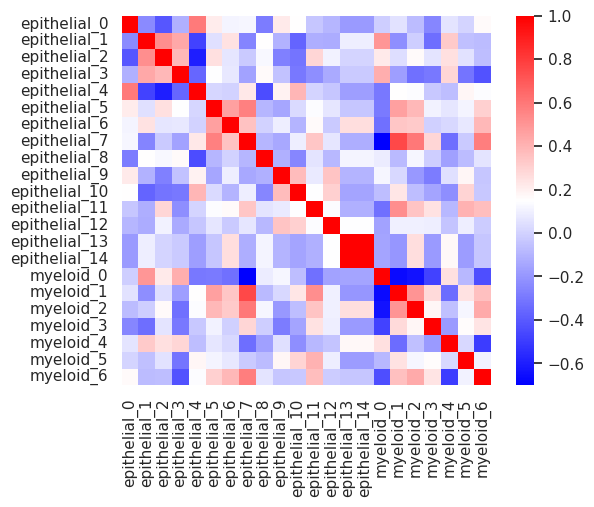

In [ ]:
sns.heatmap(pct_df.corr('spearman'),square=True,cmap='bwr')

Text(20, 80, 'stat:0.50\np-value:6.25e-04')

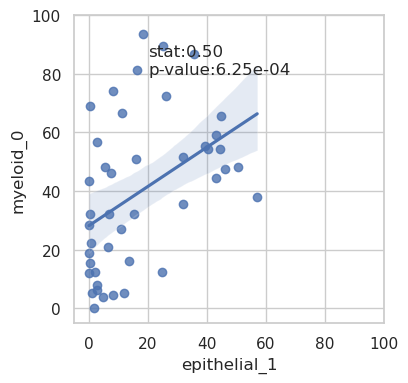

In [ ]:
from scipy.stats import spearmanr, pearsonr

# Myeloid 1: IL1A_IL1B
# Epithelial 1: club
# Epithelial 2: hillock
# Epithelial 2: basal

# myeloid_1 --> epithelial_7 is a pair
# myeloid_0 --> epithelial_1 is a pair

mye_grp = 'myeloid_0'
epi_grp = 'epithelial_1'
#pearsonr(pct_df[epi_grp],pct_df[mye_grp])
stat, pval = spearmanr(pct_df[epi_grp],pct_df[mye_grp])

fig, ax = plt.subplots(figsize=(4,4))
sns.regplot(
    pct_df,
    x = epi_grp,
    y = mye_grp,
    ax = ax 
)
ax.set_xlim(-5,100)
ax.set_ylim(-5,100)
ax.text(x=20,y=80,s=f'stat:{stat:.2f}\np-value:{pval:.2e}')

In [80]:
#sc.tl.rank_genes_groups(adata, groupby='phenotype', groups='all', method='wilcoxon',random_state=3564923058)
deg_df = sc.get.rank_genes_groups_df(adata, group=None, pval_cutoff=0.05, log2fc_min=1)

In [ ]:
deg_df[deg_df['group'] == 'PCa'][:30]

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,PCa,DNAJB1,48.150265,4.106858,0.000000e+00,0.000000e+00
1,PCa,HSPA1A,46.442860,3.700883,0.000000e+00,0.000000e+00
2,PCa,HSPA1B,43.995903,3.729681,0.000000e+00,0.000000e+00
3,PCa,BAG3,42.538025,5.533723,0.000000e+00,0.000000e+00
4,PCa,HSPH1,42.094944,3.636453,0.000000e+00,0.000000e+00
5,PCa,HSPB1,41.652996,2.954957,0.000000e+00,0.000000e+00
6,PCa,HSP90AA1,41.600941,2.460804,0.000000e+00,0.000000e+00
7,PCa,HSPE1,39.202808,2.634704,0.000000e+00,0.000000e+00
8,PCa,HSPD1,39.158051,2.869122,0.000000e+00,0.000000e+00
9,PCa,RGS1,38.270321,2.661808,0.000000e+00,0.000000e+00


In [ ]:
deg_df[deg_df['names'].isin(['SPP1'])]

,group,names,scores,logfoldchanges,pvals,pvals_adj
740,mCRPC,SPP1,6.308018,1.649863,2.826307e-10,1.782330e-08


categories: 0, 1, 2, etc.
var_group_labels: Macrophage, IL1AB immunosuppression, SPP1hi TAMs, etc.


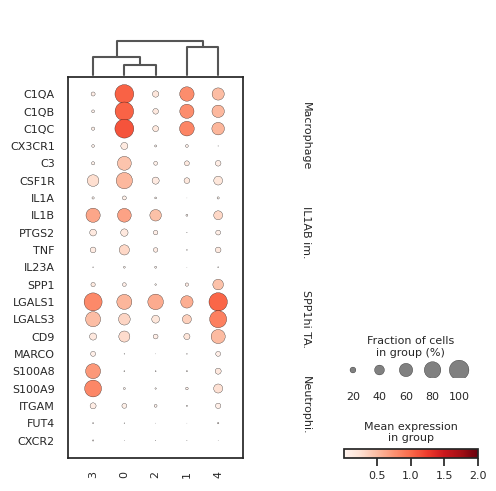

In [ ]:
myeloid_subset_markers= {
    'Macrophage':['C1QA','C1QB','C1QC','CX3CR1','C3','CSF1R'],
    'IL1AB immunosuppression':['IL1A','IL1B','PTGS2','TNF','IL23A'],
    'SPP1hi TAMs':['SPP1','LGALS1','LGALS3','CD9','MARCO'],
    'Neutrophil':['S100A8','S100A9','ITGAM','FUT4','CXCR2',],
}

sns.set_theme(style='white', font_scale=0.8)
sc.tl.dendrogram(adata, groupby='leiden_myeloid', use_rep='X_pca')
fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.dotplot(adata, 
    myeloid_subset_markers, 
    groupby='leiden_myeloid', 
    dendrogram=True, 
    log=True, 
    swap_axes=True, 
    ax=ax, 
    vmax=2, 
    show=False)
plt.tight_layout()

## Cluster single-cell datasets individually to find myeloid cells

In [2]:
def keep_specified_markers(marker_list, keep_vals):
    new_marker_list = {}
    for k, v in marker_list.items():
        new_marker_list[k] = [val for val in v if val in keep_vals]
    return new_marker_list


refined_markers = {
    'Epithelial': ['EPCAM', 'KRT18', 'KRT8','KLK3','AR', 'MSMB','KRT5', 'KRT15', 'TP63', 'KRT7', 'KRT19', 'KRT4'],
    'Endothelial': ['VWF', 'SELE', 'FLT1', 'ENG'],
    'Fibroblast': ['LUM', 'DCN', 'IGF1', 'APOD', 'STC1', 'FBLN1', 'COL1A2', 'C7', 'IGFBP5', 'ACTA2'],
    #'CAFs':['FAP','NDRG2', 'TSPAN1', 'PTN', 'APOE', 'OR51E2', 'P4HB', 'STEAP1','ABCC4'], # From here https://www.nature.com/articles/s41598-023-36125-0
    #'metCAFs':['ITGA11','THBS1','FN1','EMP1','ITGA2','FYN','SPP1','EMP2'], # from here https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-024-05413-2
    #'iCAFs':['IL13RA2', 'GDF7', 'IL33', 'CXCL1', 'TNFRSF19', 'CXCL6', 'LIFR', 'CXCL5', 'IL7','TSLP','TNFSF15'],
    'SMC': ['RGS5', 'ACTA2', 'TAGLN', 'BGN', 'MYL9', 'MYLK','CALD1',],
    'Mast': ['KIT', 'TPSB2', 'TPSAB1', 'CPA3', 'VWA5A', 'IL1RL1', 'CTSG', 'SLC18A2', 'ACSL4', 'MS4A2', 'GATA2'],
    'T cell': ['CD3D', 'CD3E', 'CD3G', 'CD8A', 'CD8B', 'IL7R'],
    'B cell': ['CD79A', 'MS4A1', 'CD79B', 'IGHM', 'CD83'],
    'Myeloid': ['CD4', 'C1QA', 'C1QB', 'C1QC', 'CD68', 'LYZ', 'IL1B', 'S100A9', 'S100A8','CXCL8','FCGR3A', 'CSF1R',],
    'Neuronal': ['PLP1', 'MPZ', 'MT1H'],
    'Dendritic': ['IRF7', 'IRF4', 'FCER1A', 'CD1C'],
    'Plasma': ['IGJ', 'MZB1']
}



In [ ]:
# Load data
adata_dict = load_from_pickle('../prostate_spatial/sc-reference/normalized_sc_8_datasets.pickle')
datasets = list(adata_dict.keys())


In [ ]:
# Without excluding any clusters

for name in tqdm(datasets,unit='dataset'):
    adata  = adata_dict[name]
    adata.var_names_make_unique()
    sc.pp.highly_variable_genes(adata,n_top_genes=2000)
    sc.tl.pca(adata, random_state=215462475)
    sc.pp.neighbors(adata, random_state=215462475)
    sc.tl.leiden(adata, key_added="leiden",resolution=1)
    sc.tl.umap(adata,random_state=215462475)



### Plot dotplots separately for each dataset

In [ ]:

sns.set_theme(style='white',font_scale=0.8)
for dataset in datasets[-7:]:
    adata = adata_dict[dataset]        
    markers = keep_specified_markers(refined_markers, adata.var_names.tolist())
    sc.tl.dendrogram(adata,groupby='leiden',use_rep='X_pca')
    fig,ax = plt.subplots(figsize=(6,12))
    sc.pl.dotplot(adata, markers, groupby='leiden', dendrogram=True, log= False,
                swap_axes = True, vmax=4,
                ax=ax,show=False,
                )
    plt.tight_layout()
    plt.savefig(f'./plots/scs_dataset_dotplots/{dataset}_celltype_marker_dotplot_with_CAFs.png',dpi=120)
    plt.savefig(f'./plots/scs_dataset_dotplots/{dataset}_celltype_marker_dotplot_with_CAFs.pdf')



### Plot UMAPs separately for each dataset

In [1]:
### Plot UMAPs separately for each dataset for cell type identification
sns.set_theme(style='white',font_scale=1)
for dataset in datasets[-7:]:
    adata = adata_dict[dataset]        
    fig,ax = plt.subplots(figsize=(5,5))
    sc.pl.umap(adata, color='leiden', ax=ax,show=False,legend_loc="on data")
    plt.tight_layout()
    plt.savefig(f'./plots/scs_dataset_umaps/{dataset}_celltype_cluster_umap.png',dpi=120)
    plt.savefig(f'./plots/scs_dataset_umaps/{dataset}_celltype_cluster_umap.pdf')



NameError: name 'sns' is not defined

### Subset to myeloid and create subclusters

In [ ]:
myeloid_clusters = {
    'henry_2018':['15'], 
    'dong_2020': ['4'], 
    'chen_2021': ['7'], 
    'cheng_2022': ['15'], 
    'chen_2022': ['13','16'], 
    'song_2022':['2','17','19','21'], 
    'wong_2022':['2','18'], 
    'hirz_2023':['2','17','24','28']
    
}

myeloid_adata_dict = {}


# Subset each dataset to only contain cells of the myeloid lineage
for k in list(myeloid_clusters.keys()):
    myeloid_adata_dict[k] = adata_dict[k][adata_dict[k].obs['leiden'].isin(myeloid_clusters[k])].copy()


# Number of annotated myeloid cells in each dataset:
'''
henry_2018: 293
dong_2020: 1508
chen_2021: 1762
cheng_2022: 473
chen_2022: 1267
song_2022: 2743
wong_2022: 4967
hirz_2023: 12710

'''


### Perform subclustering of myeloid cells

In [ ]:
# Without excluding any clusters
for name in datasets:
    adata  = myeloid_adata_dict[name]
    sc.pp.highly_variable_genes(adata,n_top_genes=2000)
    sc.tl.pca(adata, random_state=23523556)
    sc.pp.neighbors(adata, random_state=23523556)
    sc.tl.leiden(adata, key_added="leiden_myeloid",resolution=0.36)
    sc.tl.umap(adata,random_state=23523556)


### Plot UMAPs of subclustered myeloid cells

In [ ]:
### Plot UMAPs separately for each dataset for cell type identification
sns.set_theme(style='white',font_scale=1)
for dataset in datasets[-7:]:
    adata = myeloid_adata_dict[dataset]        
    fig,ax = plt.subplots(figsize=(4,3))
    sc.pl.umap(adata, color='leiden_myeloid', ax=ax,show=False)
    plt.tight_layout()
    plt.savefig(f'./plots/scs_dataset_umaps/{dataset}_myeloid_subset_cluster_umap.png',dpi=120)
    plt.savefig(f'./plots/scs_dataset_umaps/{dataset}_myeloid_subset_cluster_umap.pdf')



In [ ]:
# Score the gene sets of interest

for name in datasets:
    # Score the NMF-derived epithelial modules
    adata  = myeloid_adata_dict[name]
    for mod in pdac_tam_markers:
        lst = pdac_tam_markers[mod].dropna().tolist()
        sc.tl.score_genes(adata, gene_list=lst, use_raw=False, score_name=mod, ctrl_size=len(lst), random_state=4368456)


# Save the object into pickle
save_to_pickle(myeloid_adata_dict,'./adata_dict_single_cell_myeloid_subsets_20241112.pkl')

## Analyze myeloid subsets in the notebook

In [45]:
adata_dict = load_from_pickle('./adata_dict_single_cell_myeloid_subsets_20241112.pkl')
datasets = list(adata_dict.keys())


/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


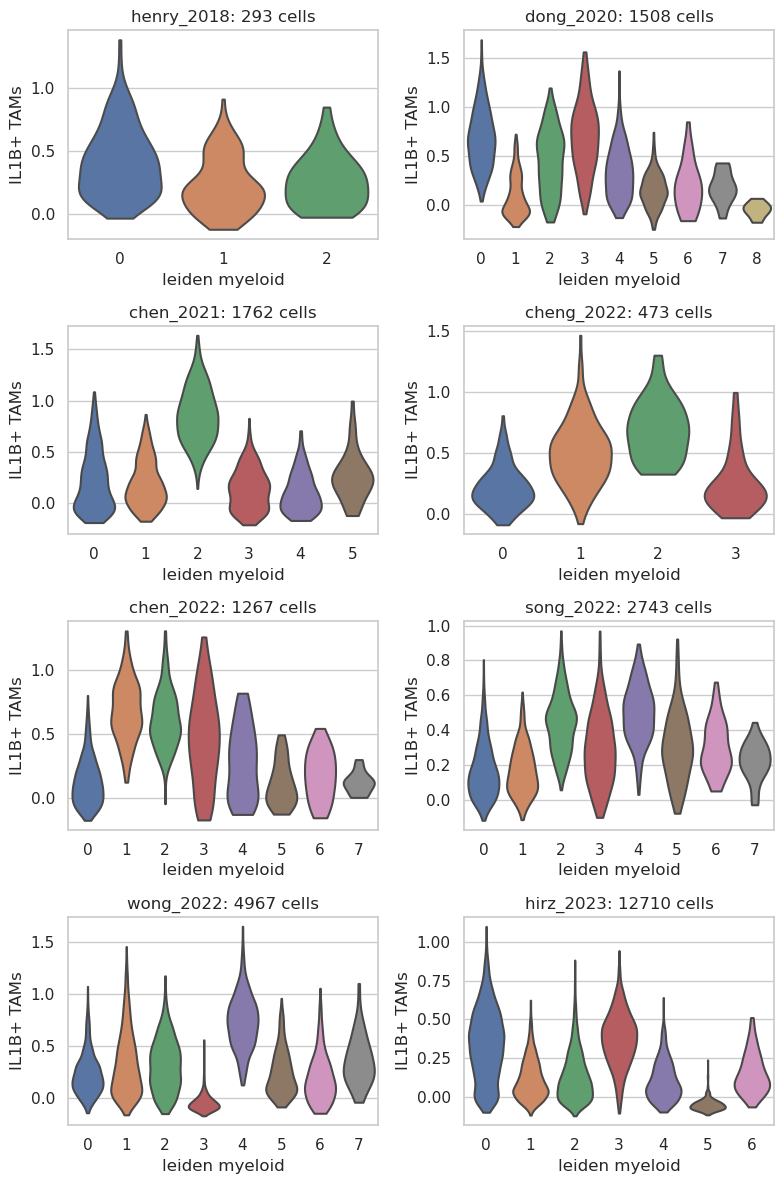

In [46]:
# Visualize the expression of a single gene

gene = 'IL1B+ TAMs'

sns.set_theme(style='whitegrid')

fig, axs = plt.subplots(4, 2, figsize=(8, 12))

# Flatten the axs array for easier iteration
axs = axs.flatten()

for idx, dataset in enumerate(datasets):
    
    adata = adata_dict[dataset].copy()
    ax = axs[idx]
    sc.pl.violin(
        adata,
        groupby='leiden_myeloid',
        use_raw=False,
        keys=gene,
        stripplot=False,
        ax=ax,
        show=False,
    )
    ax.set_title(f'{dataset}: {len(adata)} cells')

plt.tight_layout()
plt.show()



In [8]:
from tqdm import tqdm
deg_sheets_dict = {}

for dataset in tqdm(datasets):
    # Calculate

    adata = adata_dict[dataset]
    sc.tl.rank_genes_groups(adata,
        groupby='leiden_myeloid',
        groups = 'all',
        method='wilcoxon'
    )


    df_list = []
    for clust in adata.obs['leiden_myeloid'].cat.categories:
        df = sc.get.rank_genes_groups_df(adata,group = clust,pval_cutoff = 0.05, log2fc_min = 1)
        df['cluster_res0.36'] = f'cluster{clust}'
        df_list.append(df)

    deg_cluster_markers = pd.concat(df_list, axis=0)

    deg_sheets_dict[dataset] = deg_cluster_markers
    deg_cluster_markers.to_excel('./prostate_monocyte_cluster_markers.xlsx')

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [01:49<00:00, 13.73s/it]


In [20]:
valid_clusters = []

for dataset in datasets:
    df = deg_sheets_dict[dataset]
    df = df.drop(columns=['pvals'])

    for cl in df['cluster_res0.36'].unique():
        subset = df[df['cluster_res0.36'] == cl]

        # Both IL1A and IL1B are overexpressed in this cluster
        # Save all the DEs separately
        if (subset['names'].isin(['IL1A','IL1B']).sum() == 2):
            subset['cluster_res0.36'] = dataset + '_' + subset['cluster_res0.36']
            valid_clusters.append(subset)
        

deg_res_df = pd.concat(valid_clusters,axis=0)

<ipython-input-20-619a80f6314e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['cluster_res0.36'] = dataset + '_' + subset['cluster_res0.36']
<ipython-input-20-619a80f6314e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['cluster_res0.36'] = dataset + '_' + subset['cluster_res0.36']
<ipython-input-20-619a80f6314e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [21]:
deg_res_df.to_excel('./prostate_monocyte_cluster_markers.xlsx')

In [13]:
deg_res_df = pd.read_excel('./prostate_monocyte_cluster_markers.xlsx')
min_n_datasets = 4
il1a_il1b_signature = deg_res_df['names'].value_counts()[deg_res_df['names'].value_counts() >= min_n_datasets].index.tolist()
print(len(il1a_il1b_signature))

71


In [14]:
print(il1a_il1b_signature)

['IL1A', 'PTGS2', 'IL1B', 'CXCL3', 'TNFAIP3', 'IER3', 'CCL3', 'NFKBIZ', 'NFKBIA', 'CXCL2', 'SOD2', 'LUCAT1', 'PLEK', 'CCL20', 'KYNU', 'G0S2', 'NAMPT', 'PNRC1', 'PPIF', 'BCL2A1', 'CD93', 'EREG', 'NLRP3', 'THBS1', 'AQP9', 'CD55', 'ACSL1', 'FNDC3B', 'TREM1', 'C5AR1', 'ELL2', 'CD44', 'DUSP6', 'AREG', 'WTAP', 'TNFAIP6', 'B4GALT5', 'GCH1', 'IL1RN', 'MXD1', 'ATP2B1', 'ATP13A3', 'EHD1', 'CXCL1', 'SLC25A37', 'SAMSN1', 'OLR1', 'ZEB2', 'EAF1', 'RNF19B', 'THBD', 'OTUD1', 'CXCL8', 'ANPEP', 'SERPINB2', 'TIMP1', 'CCL4', 'CCL3L1', 'SAV1', 'BTG1', 'S100A8', 'SRGN', 'ICAM1', 'GK', 'FCN1', 'VCAN', 'RASGEF1B', 'MARCKS', 'S100A9', 'SLC11A1', 'NEAT1']


In [15]:
PMN_MDSC_signature = ['STAT1','STAT3','STAT6','NFKB1','IRF1','S100A9','S100A8','ANXA1','LYZ2',
                     'CXCL1','CXCL2','CXCR1','CXCR2','CXCL8','LILRA3','TREM1','PTGS2','ARG1','ARG2'
                     'TGFB1','VEGF','IL6','CSF1','IL1B','WFDC17','IL4R','OLR1','CD84']

club_region_signature = ['SLPI','MMP7','ELF3','TNFAIP2','MUC1','CLDN4','PIGR','CP','GPRC5A','TNFRSF21','KRT7','RHOV','NCOA7','GABRP','LXN','ITGB6','S100P','KRT19','LCN2','CFB','CLDN1','ASS1','ATP1B1','CDH3','KRT17','LTF','ANXA2','KLF5','S100A2','VMP1','CXCL17','WFDC2','RARRES1','CEACAM1','DUSP4','TNFSF15','NPC2','SCUBE2','MPZL2','PI3','CXCL1','CXCL16','SOD2','OLFM4','CXCL2','PRSS22','CFTR','ST6GAL1','MET','ATF3','CRABP2','SCNN1A','BCL3','SERPINA1','SCGB3A1','PTGES','MUC4','S100A9','PTGS2','LAMB3','EPHA2','PIM3','UBD','ALS2CL','TJP3','TMEM63A','PDZK1IP1','C19orf33','MYH14','MACC1','ITGA3','ID1','LAMC2','PTPRK','SOX9','ACSL5','TMEM45B','BACE2','NTN4','GRB7','CXCL6','SAA1','RNF145','CXCL3','SEMA4B','SLC5A1','TNFSF10','TM4SF1','PLPP2','BIRC3','SDC4','AQP3','TACSTD2','KRT23','PLEKHS1','BTG3','AHR','VNN2','ACHE','KCNQ1','GABRE','ERP27','DRAM1','ITGB4','ADGRF1','S100A11','INAVA','S100A14','CEBPB','CLDN7','AC254629.1','KLK10','STEAP3','AC020916.1','LIMK2','SLC15A2','KRT80','AL049839.2','PPL','DHRS3','RARRES3','DDR1','TRIM29','ZC3H12A','RNF207','DKK1','KRT8','GGT6','ERBB2','PLAU','KRT5','SHB','MUC3A','KRT15','RAB11FIP1','PADI2','SLC26A4','GSTA1','EDN1','ABCC3','PHLDA2','TRAF4','AGR2','OCLN','SDC1','DUSP23','MYO1B','SHROOM3','ODF3B','RUNX1','ITGB8','DEFB1','ARHGAP26','BAG1','CXCL8','EPS8L2','TMC5','JUP','PDE4B','GADD45A','NCEH1','KRT4','SUSD6','VTCN1','KIAA1671','BPIFB1','GLUL','PROM1','PLEKHA6','TNS4','PERP','CXADR','ZFP36L1','TGM2','NGFR','DUSP5','FAM3D','CCL2','FMO5','SBNO2','CYP4F12','ATP1A1','AGRN','TFCP2L1','S100A16','GRHL1','EPS8L1','RGCC','TNFRSF12A','PAPSS1','C12orf49','LRG1','ACSF2','AC007906.2','CRACR2B','ETS2','HBEGF','EFNA1','RIPK4','CHPT1','ITPKC','RAB15','LOXL4','EGLN3','PNPLA2','CCL20','LIMA1','CAPN8','PTPRU','ZSWIM4','CLDN10','PPP1R13L','KCNK1','TYMP','SERINC2','NFKBIA','FLRT3','MISP','GPX2','CTSH','ST14','HES1','MECOM','BICDL2','FOXQ1','BHLHE40','IGFBP3','SAT1','AUTS2','DCDC2','TPBG','SLC5A6','RARG','ETV6','EXPH5','TCIM','MYOF','NEURL3','NEDD9','CD82','PROM2','F3','SORL1','SPINT1','EZR','GATA3','MPZL3','CHI3L2','IRF1','CREB3L1','LINC02009','C5orf46','NECTIN4','SIRPA','ERO1A','GSAP','GDF15','HSBP1L1','NPAS2','ERRFI1','ARRDC2','PLD2','BMP2','C1RL','PDXK','B3GNT3','RBM7','TMEM45A','CYP24A1','FGFBP1','AL591895.1','SPP1','PTP4A1','SELENBP1','WNT7B','FRAS1','PATJ','HK2','EDN2','MICALL2','RIN2','SPIB','KCNN4','F11R','SLC44A4','FCGBP','CX3CL1','KRTCAP3','DDIT4','NFKBIZ','CHL1','ZFP36L2','INPP5J','SDC2','IVNS1ABP','GNA15','IFNGR1','NFIB','SLC11A2','IFNGR2','SYNE2','MIDN','TF','MARCKS','CLEC3A','TFRC','KIAA1217','FHL2','SH2D3A','ARRDC3','TFF1','RAB20','GJB3','CTSB','CST6','GNPTAB','ARHGEF28','CDCP1','SERPINB1','DTX4','SLC35C1','ENC1','TNS3','SFN','SLC4A4','ESPN','DLG5','ADGRG6','SAA2','KLF6','MUC20','LLGL2','DEPP1','CTNND1','TP53I3','WEE1','C2orf54','MGAT4B','SLC34A2','PSME2','SMURF1','RELB','SLC43A2','ZMIZ2','ITGA2','TMEM178A','FUT2','PARP4','NFKB2','CXCL5','SPTSSB','ABHD11','RALGDS','IER5','EVA1C','TFAP2A','KIAA1522','PI15','KRT13','CNFN','SH3BP4','LGALS3','PABPC1L','HLA-F','MAST4','FAT1','HS6ST1','PCDH8','TAPBP','B3GNT5','GALNT18','IFFO2','CLCF1','CHAC1','PISD','MMP10','FAM110C','HS3ST1','TUBA1C','KRT16','FMO2','CHI3L1','CLDN3','KRT18','MAL2','TFAP2C','SLC40A1','IER3','CEBPD','LYZ','SUSD4','TSPAN12','ITPR3','RASD1','HLA-DMA','FBP1','THSD4','FAAH2','PPP1R1B','ROBO1','UNC93B1','MAP3K1','PLCH2','MYO5C','MAFF','CELSR1','BSPRY','KLK11','IER2','LSR','TMEM123','TRAM1','USP54','HLA-DQB1','TRIM47','OSBPL10','DAB2IP','GPR87','STAC2','ADK','TBC1D2','WWC1','ADGRG1','IRX3','DMKN','TM7SF3','TRIM2','NFIL3','CFI','TTC7A','B4GALT1','TRIB1','PTPN3','ERBB3','ICAM1','RAB25','PRR15L','TAP1','PDE8B','TRPV4','TNFRSF10B','SECTM1','AMOT','TSPAN15','PLSCR1','SLC4A11','CITED4','NNMT','PPFIBP2','VAMP8','CLMN','OCIAD2']

sig = PMN_MDSC_signature
sig2 = il1a_il1b_signature
#sig2 = PMN_MDSC_signature

overlap = list(set(sig2).intersection(set(sig)))

from scipy.stats import fisher_exact

print(overlap)

a = len(overlap)
b = len(sig) - a
c = len(sig2) - a
d = len(adata) - len(sig2)

arr = np.array([[a,b],[c,d]])
stat, pval = fisher_exact(arr)

print(f'p = {pval:.2e}')

['S100A8', 'CXCL1', 'PTGS2', 'CXCL8', 'IL1B', 'S100A9', 'CXCL2', 'TREM1', 'OLR1']
p = 1.34e-14


### Investigate these differences in relation to phenotype

In [ ]:
# Leave out Henry et al. data as they don't contain IL1A/IL1B positive cells
adata_dict.pop('henry_2018')

In [15]:
import anndata as ad
concat_adata = ad.concat(adata_dict,join='outer')

# Add the myeloid cluster information
concat_adata.obs['cluster'] = concat_adata.obs['dataset']+'_cluster'+concat_adata.obs['leiden_myeloid']

# Order the phenotypes
concat_adata.obs['phenotype'] = pd.Categorical(concat_adata.obs['phenotype'],categories = ['normal','PCa','CRPC'])

'IL1A/IL1B positive clusters'
celltype_positive_clusters = [
    'dong_2020_cluster3',
    'chen_2021_cluster2',
    'cheng_2022_cluster2',
    'chen_2022_cluster1',
    'song_2022_cluster2',
    'wong_2022_cluster4',
    'hirz_2023_cluster3'
    ]

/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


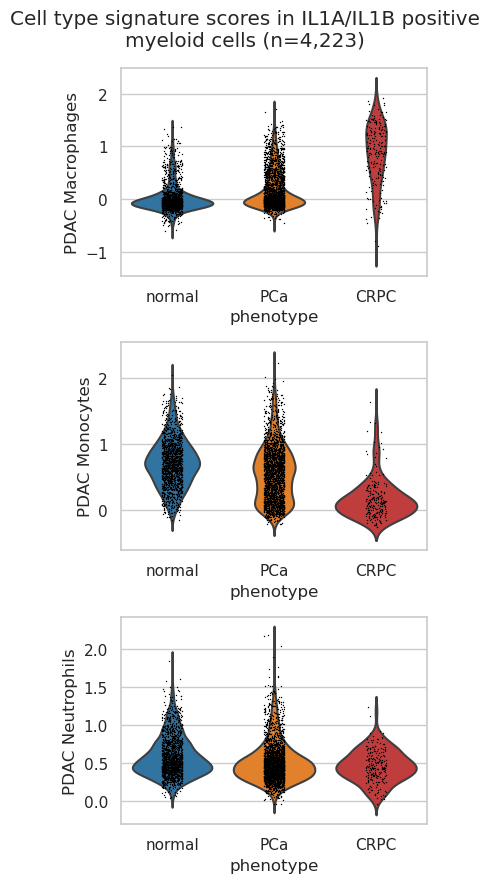

In [25]:
il1_postive_myeloids_adata = concat_adata[concat_adata.obs['cluster'].isin(celltype_positive_clusters)]

pal = sns.color_palette('tab10')
sns.set_theme(style='whitegrid',palette = sns.color_palette([pal[0],pal[1],pal[3]]))

fig, axs = plt.subplots(3,1,figsize=(4,9))

# Flatten the axs array for easier iteration
axs = axs.flatten()


for idx,geneset in enumerate(['PDAC Macrophages','PDAC Monocytes','PDAC Neutrophils']):

    plot_df = il1_postive_myeloids_adata.obs[['phenotype','dataset',geneset]]
    ax = axs[idx]
    sns.stripplot(plot_df,
        x = 'phenotype',
        y = geneset,
        size= 1,
        color='black',
        ax= ax
    )

    sns.violinplot(plot_df,
        x = 'phenotype',
        y = geneset,
        inner= None,
        ax= ax
    )

plt.suptitle('Cell type signature scores in IL1A/IL1B positive\nmyeloid cells (n=4,223)')
plt.tight_layout()
plt.show()

### Investigate the odds ratios

In [32]:
df = concat_adata.obs.copy()

df.loc[:,'IL1A+/IL1B+ MDSCs'] = 'no'
df.loc[df[df['cluster'].isin(celltype_positive_clusters)].index,'IL1A+/IL1B+ MDSCs'] = 'yes'
df['IL1A+/IL1B+ MDSCs'] = pd.Categorical(df['IL1A+/IL1B+ MDSCs'],categories = ['yes','no'])

for phtype in df['phenotype'].cat.categories:
    df.loc[:,phtype] = 'no'
    df.loc[df[df['phenotype'] == phtype].index,phtype] = 'yes'
    df[phtype] = pd.Categorical(df[phtype],categories = ['yes','no'])


In [40]:
from scipy.stats import fisher_exact

phenotypes = df['phenotype'].cat.categories.tolist()

print('The odds ratios for IL1A+/IL1B+ myeloid cells')
for phtype in phenotypes:
    crosstab = pd.crosstab(df[phtype],df['IL1A+/IL1B+ MDSCs'])
    stat, pval = fisher_exact(crosstab)

    print(f'{phtype}: Oddsratio = {stat:.2f}, p-value = {pval:.2e}')
    #oddsratio_df.loc[phtype,'IL1A+/IL1B+ MDSCs'] = stat
    #pval_df.loc[phtype,'IL1A+/IL1B+ MDSCs'] = pval


normal: Oddsratio = 1.39, p-value = 3.97e-20
PCa: Oddsratio = 0.81, p-value = 2.25e-09
CRPC: Oddsratio = 0.68, p-value = 4.08e-08


In [ ]:

log_oddsratio_df = np.log2(oddsratio_df)

annot = pd.DataFrame('',index = pval_df.index, columns = pval_df.columns)
annot[pval_df < 0.05] = '*'